   # Some Functions For Open Field Test for mice

This is done after tracking using DeepLabCut AND generating the .h5 with the x,y coordinates in each frame

In [36]:
#import essential modules

import os
import h5py #top open h5 binary files
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

np.set_printoptions(suppress=True) #suppress sciebntific notations

In [7]:
#create trajectory map
def draw_trajectory(filename): #needs one argument, the h5 file name or the video if they have the same name
    
    #get the file directory
    file_dir = os.path.dirname(filename)
    
    
    filename_without_ext = os.path.splitext(os.path.basename(filename))[0] #remove the extension
    
    #import the .h5 file and extract the x,y coordinates in each frame
    h5_file = h5_file = file_dir + '/' + filename_without_ext + '.h5' #you need the abs path to work properly
    f = h5py.File(h5_file, 'r')

    print("Keys: %s" % f.keys())

    #Get the keys from the file
    a_group_key = list(f.keys())[0]

    #convert the keys to a dataframe to make them easier to handle and to plot
    data = pd.read_hdf(h5_file, a_group_key)

    x = data.iloc[330:, 0][data.iloc[:,2]>0.7] #Remove the first 300 frames to compensate for confusion at the beginning
    y = data.iloc[330:, 1][data.iloc[:,2]>0.7]
    
    
    #create trajectory
    #you can control the outliers by modifying the likelihood value [data.iloc[:,2]>0.7]
    plt.figure(figsize=(4,4), dpi=300)
    plt.plot(x,y, color='k', linewidth=1)
    plt.axis('off')
    plt.gca().invert_yaxis() #otherwise the images appear mirror imaged
    plt.savefig('%s/%s_Trajectory.png' % (file_dir,filename_without_ext))
    
    

Keys: KeysView(<HDF5 file "R51_Test_day_24h_delay_OR_Exp_2017_05_05_R50.51.52.53.54.48_20170510_101316_compressed.h5" (mode r)>)


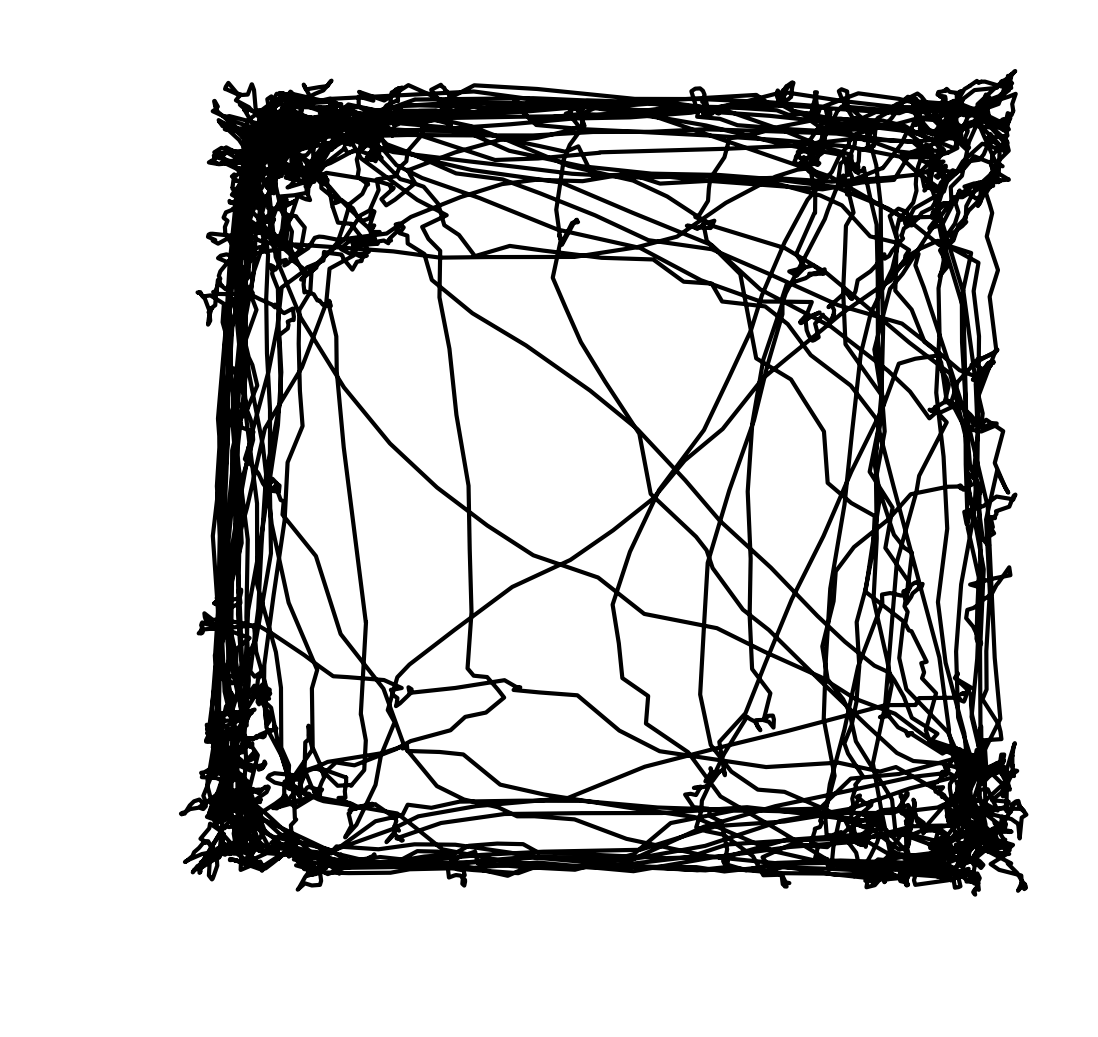

In [8]:
draw_trajectory(filename)

In [9]:
#Create density maps
def draw_density_map(filename):
    from scipy.stats import kde #kernel density estimate
    
    #get the file directory
    file_dir = os.path.dirname(filename)
    
    
    filename_without_ext = os.path.splitext(os.path.basename(filename))[0] #remove the extension
    
    #import the .h5 file and extract the x,y coordinates in each frame
    h5_file = h5_file = file_dir + '/' + filename_without_ext + '.h5' #you need the abs path to work properly
    f = h5py.File(h5_file, 'r')

    print("Keys: %s" % f.keys())

    #Get the keys from the file
    a_group_key = list(f.keys())[0]

    #convert the keys to a dataframe to make them easier to handle and to plot
    data = pd.read_hdf(h5_file, a_group_key)

    x = data.iloc[330:, 0][data.iloc[:,2]>0.7] #Remove the first 300 frames to compensate for confusion at the beginning
    y = data.iloc[330:, 1][data.iloc[:,2]>0.7]
     
    
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    nbins=300 #300 is a very good compromise both computationally and aesthetically 
    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    plt.figure(figsize=(6,4), dpi=300)
    plt.pcolormesh(xi, yi, (zi.reshape(xi.shape) - zi.min())/(zi.max()), cmap='jet') #normalize zi value to get colorbar from 0-1
    plt.colorbar(ticks=[0,0.2,0.4,0.6,0.8,1])
    plt.axis('off')
    plt.gca().invert_yaxis()
    
    plt.savefig('%s/%s_Density.png' % (file_dir,filename_without_ext))
    

Keys: KeysView(<HDF5 file "R51_Test_day_24h_delay_OR_Exp_2017_05_05_R50.51.52.53.54.48_20170510_101316_compressed.h5" (mode r)>)


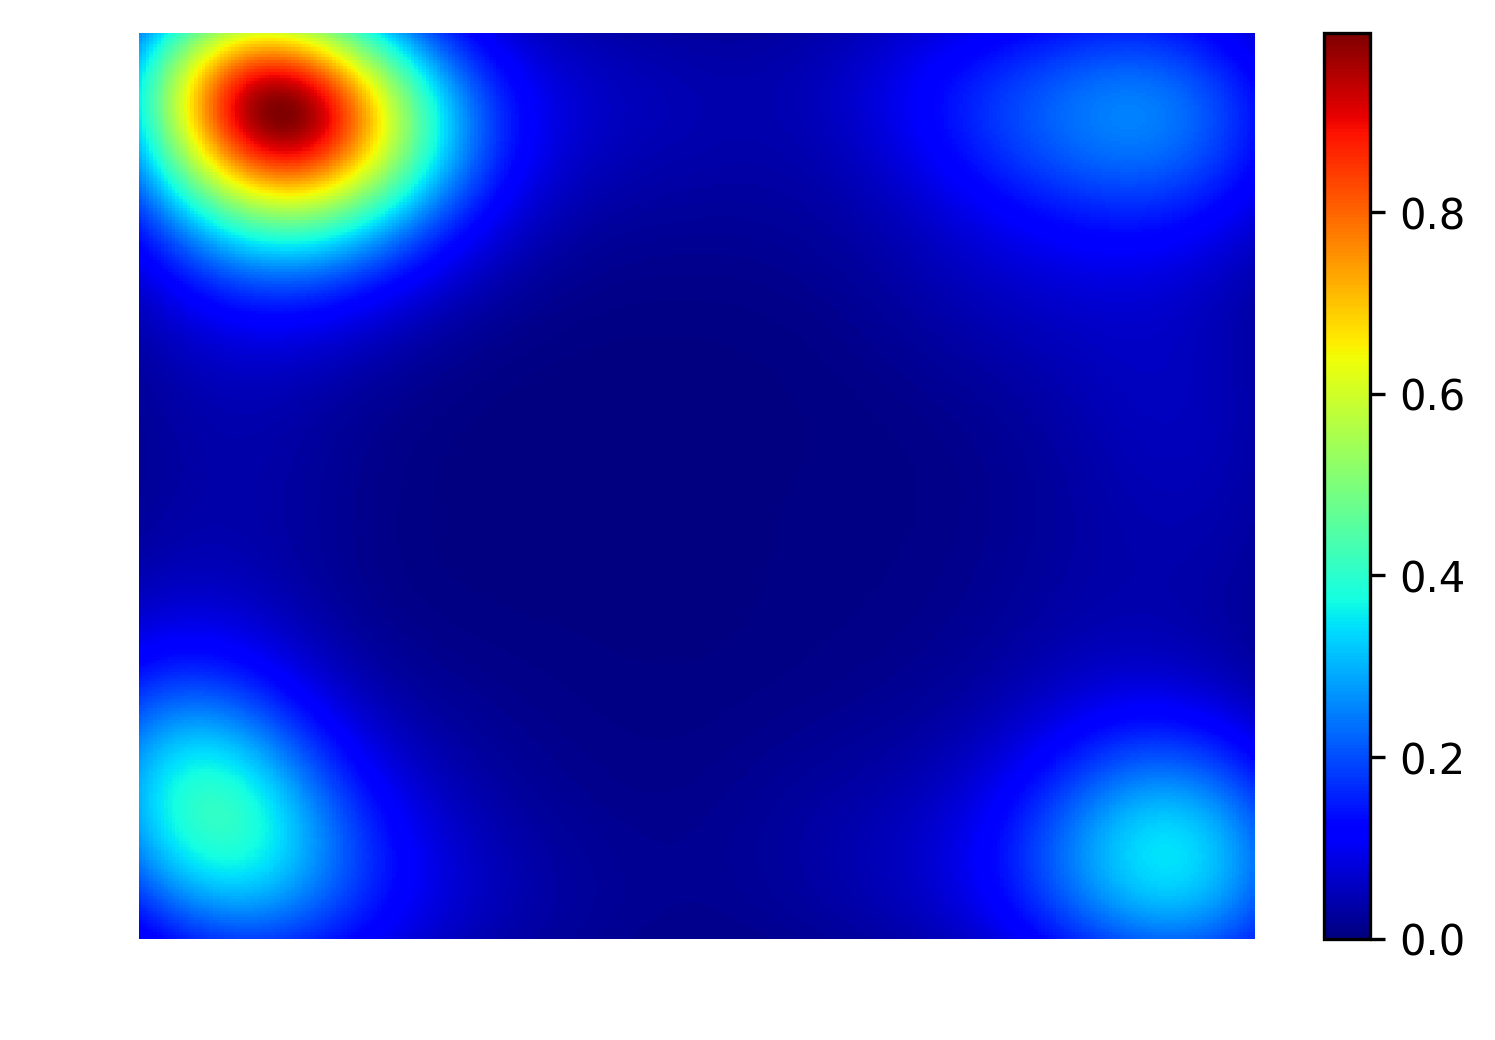

In [10]:
draw_density_map(filename)

In [20]:
#calculate the total distance traveled by the animal
def calculate_distance(filename):
    #get the file directory
    file_dir = os.path.dirname(filename)
    
    
    filename_without_ext = os.path.splitext(os.path.basename(filename))[0] #remove the extension
    
    #import the .h5 file and extract the x,y coordinates in each frame
    h5_file = h5_file = file_dir + '/' + filename_without_ext + '.h5' #you need the abs path to work properly
    f = h5py.File(h5_file, 'r')

    print("Keys: %s" % f.keys())

    #Get the keys from the file
    a_group_key = list(f.keys())[0]

    #convert the keys to a dataframe to make them easier to handle and to plot
    data = pd.read_hdf(h5_file, a_group_key)

    x = data.iloc[330:, 0][data.iloc[:,2]>0.7] #Remove the first 300 frames to compensate for confusion at the beginning
    y = data.iloc[330:, 1][data.iloc[:,2]>0.7]
     
     
    
    #Concatenate x,y coordinates vectors in the same matrix    
    Z = np.column_stack((x,y))
    
    #we need to calculate the euclidean distance between each two consecutive frames
    #so we make two matrices and remove the last frame from the first and the first frame from the second
    #aka each two corresponding rows are two consecutive frames
    #I tried to do it with euclidean distance in scipy, but it is more computationally expensive
    #and gives exactly the same result
    Z1 = Z[0:-1]  
    Z2 = Z[1:, :]
    
    #the euclidean distance formula:  dist((x, y), (a, b)) = √(x - a)² + (y - b)²
    diff = (Z1 - Z2)
    
    squared = diff**2
    sumed = np.sum(squared, axis=1)
    distances = np.sqrt(sumed)
    total_distance = np.sum(distances)
    #the square root of the sum of squared differences
    print ('Total distance traveled by the animal is: %s pixel' %total_distance)
    return total_distance, Z
    
    

In [21]:
calculate_distance(filename)

Keys: KeysView(<HDF5 file "R51_Test_day_24h_delay_OR_Exp_2017_05_05_R50.51.52.53.54.48_20170510_101316_compressed.h5" (mode r)>)
Total distance traveled by the animal is: 25206.452916834074 pixel


(25206.452916834074, array([[93.75414562, 29.34574854],
        [88.89768791, 27.81913686],
        [87.63882589, 26.72769845],
        ...,
        [68.93942845, 24.71420765],
        [69.05121517, 24.47938967],
        [69.70541859, 24.66207361]]))

In [22]:
#Get numer of frames per second (fps) for each video using cv2 module
def get_fps(filename, extension): 
    #N.B: you need to enter the name of the video itself, or
    #if you want to enter .h5 name, the video has to be in the same directory
    #the h5 file name or the video if they have the same name
    import cv2
    
    #requires extension input as a string
    #get the file directory
    file_dir = os.path.dirname(filename)
    
    
    filename_without_ext = os.path.splitext(os.path.basename(filename))[0] #remove the extension
    
    video =  file_dir + '/' + filename_without_ext + extension
    
    cap = cv2.VideoCapture(video)

    #Numer of frames per second
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    
    print ('Number of Frames Per Second (fps) is: %s'%fps)
    return fps
    
    


In [23]:
get_fps(filename, '.avi')

Number of Frames Per Second (fps) is: 30


30

In [28]:
def calculate_velocity(filename):
    
    total_distance, Z = calculate_distance(filename)
    fps = get_fps(filename, '.avi')
    
    
    no_of_frames = Z.shape[0]
    no_of_sec = no_of_frames / fps
    velocity = total_distance / no_of_sec
    print ('Speed of the animal is: %s pixel/sec' %velocity)
    

In [29]:
calculate_velocity(filename)

Keys: KeysView(<HDF5 file "R51_Test_day_24h_delay_OR_Exp_2017_05_05_R50.51.52.53.54.48_20170510_101316_compressed.h5" (mode r)>)
Total distance traveled by the animal is: 25206.452916834074 pixel
Number of Frames Per Second (fps) is: 30
Speed of the animal is: 85.34916337528468 pixel/sec


In [53]:
def center_to_corners_ratio(filename, extension):#run after previous functions
    #get the file directory
    file_dir = os.path.dirname(filename)
    
    
    filename_without_ext = os.path.splitext(os.path.basename(filename))[0] #remove the extension
    
    #import the .h5 file and extract the x,y coordinates in each frame
    h5_file = h5_file = file_dir + '/' + filename_without_ext + '.h5' #you need the abs path to work properly
    f = h5py.File(h5_file, 'r')

    print("Keys: %s" % f.keys())

    #Get the keys from the file
    a_group_key = list(f.keys())[0]

    #convert the keys to a dataframe to make them easier to handle and to plot
    data = pd.read_hdf(h5_file, a_group_key)

    x = data.iloc[330:, 0][data.iloc[:,2]>0.7] #Remove the first 300 frames to compensate for confusion at the beginning
    y = data.iloc[330:, 1][data.iloc[:,2]>0.7]
        #get the file directory
    file_dir = os.path.dirname(filename)
    
    
    filename_without_ext = os.path.splitext(os.path.basename(filename))[0] #remove the extension
    
    #import the .h5 file and extract the x,y coordinates in each frame
    h5_file = h5_file = file_dir + '/' + filename_without_ext + '.h5' #you need the abs path to work properly
    f = h5py.File(h5_file, 'r')

    print("Keys: %s" % f.keys())

    #Get the keys from the file
    a_group_key = list(f.keys())[0]

    #convert the keys to a dataframe to make them easier to handle and to plot
    data = pd.read_hdf(h5_file, a_group_key)

    x = data.iloc[330:, 0][data.iloc[:,2]>0.7] #Remove the first 300 frames to compensate for confusion at the beginning
    y = data.iloc[330:, 1][data.iloc[:,2]>0.7]
     
     
    
    #Concatenate x,y coordinates vectors in the same matrix

    Z = np.column_stack((x,y))
    
    #################################################################################################################
    plt.figure(figsize=(8,6), dpi=300)
    plt.plot(x,y, color='k', linewidth=1)
    plt.axis('off')
    #plot all the frames 
    plt.plot(x,y, 'b.')
    #the same as the one above, but connecting them together helps me to see 
    #if I am missing something
    plt.plot(x,y, 'b-', alpha=0.2) 

    #get the center point by averaging the extreme points from the edges of the box
    mean = np.mean([Z.max(axis=0), Z.min(axis=0)], axis=0)
    
    #plot the mean point as an indication I am in the correct way
    plt.plot(mean[0],mean[1], 'ko')
    
    #plot the two main diagonals
    plt.plot((Z.max(axis=0)[0], Z.min(axis=0)[0]), (Z.min(axis=0)[1], Z.max(axis=0)[1]),'r', lw=1.5) 
    plt.plot((Z.max(axis=0)[0], Z.min(axis=0)[0]), (Z.max(axis=0)[1], Z.min(axis=0)[1]),'r', lw=1.5) 
    

    #get the coordinates of the center of the field based on the center point
    square_x = [(Z.min(axis=0)[0] + mean[0]) / 2,
                (Z.max(axis=0)[0] + mean[0]) / 2,
                (Z.max(axis=0)[0] + mean[0]) / 2,
                (Z.min(axis=0)[0] + mean[0]) / 2,
                (Z.min(axis=0)[0] + mean[0]) / 2] #repeat last point to close the square



    square_y = [( Z.min(axis=0)[1] + mean[1]) / 2,
                ( Z.min(axis=0)[1] + mean[1]) / 2,
                ( Z.max(axis=0)[1] + mean[1]) / 2,
                ( Z.max(axis=0)[1] + mean[1]) / 2,
                ( Z.min(axis=0)[1] + mean[1]) / 2]#repeat last point to close the square

    #plot the center sqaure
    
    plt.plot((square_x), (square_y), 'k-')
    plt.plot((square_x), (square_y), 'ko')
    
    #plot all the frames that are inside the center square
    
    plt.plot(x[x > square_x[0]][x < square_x[1]][y > square_y[0]][y < square_y[2]],y[x > square_x[0]][x < square_x[1]][y > square_y[0]][y < square_y[2]], 'r.')

    
    #now get the coordinates of the boxes at each corner of the field
    rectangle1 = plt.Rectangle(((Z.min(axis=0)[0] + mean[0] )/ 2,( Z.min(axis=0)[1] + mean[1]) / 2), 50, 50, fc='g', angle=180, alpha=.7)

    rectangle2 = plt.Rectangle(((Z.max(axis=0)[0] + mean[0] )/ 2,( Z.min(axis=0)[1] + mean[1]) / 2), 50, 50, fc='m', angle=270, alpha=.7)

    rectangle3 = plt.Rectangle(((Z.max(axis=0)[0] + mean[0] )/ 2,( Z.max(axis=0)[1] + mean[1]) / 2), 50, 50, fc='y', angle=-360, alpha=.7)

    rectangle4 = plt.Rectangle(((Z.min(axis=0)[0] + mean[0] )/ 2,( Z.max(axis=0)[1] + mean[1]) / 2), 50, 50, fc='k', angle=90, alpha=.7)


    #plot the m with different colors
    plt.gca().add_patch(rectangle1)

    plt.gca().add_patch(rectangle2)

    plt.gca().add_patch(rectangle3)

    plt.gca().add_patch(rectangle4)



    rect1_xy = rectangle1.get_xy()
    rect2_xy = rectangle2.get_xy()
    rect3_xy = rectangle3.get_xy()
    rect4_xy = rectangle4.get_xy()


    #plot the frames inside each corner rectangle with the same color as the rectangle
    #to assess things visually
    plt.plot(x[x < rect1_xy[0]][y < rect1_xy[1]],y[x < rect1_xy[0]][y < rect1_xy[1]], 'g.')

    plt.plot(x[x > rect2_xy[0]][y < rect2_xy[1]],y[x > rect2_xy[0]][y < rect2_xy[1]], 'm.')

    plt.plot(x[x > rect3_xy[0]][y > rect3_xy[1]],y[x > rect3_xy[0]][y > rect3_xy[1]], 'y.')

    plt.plot(x[x < rect4_xy[0]][y > rect4_xy[1]],y[x < rect4_xy[0]][y > rect4_xy[1]], 'k.')

#     plt.gca().invert_yaxis() #we do not need it anymore, since I am plotting a frame with plt.imshow
                               #it takes care of putting y axis to real orientation
    
    #####################################################################################################
    #get a frame and put it as background
    video = file_dir + '/' + filename_without_ext + extension
    cap = cv2.VideoCapture(video)
    success,image = cap.read()
    plt.imshow(image)
    
    plt.savefig('%s/%s_Divisions_with_bg.png' % (file_dir,filename_without_ext))
    ######################################################################################################
    
    #use the number of frames to get the time spent in each corner
    sec_in_corner1 = len(x[x < rect1_xy[0]][y < rect1_xy[1]]) / fps
    sec_in_corner2 = len(x[x > rect2_xy[0]][y < rect2_xy[1]]) / fps
    sec_in_corner3 = len(x[x > rect3_xy[0]][y > rect3_xy[1]]) / fps
    sec_in_corner4 = len(x[x < rect4_xy[0]][y > rect4_xy[1]]) / fps
    
    #the same with the center
     
    sec_in_center = len(x[x > square_x[0]][x < square_x[1]][y > square_y[0]][y < square_y[2]]) / fps
    percent_in_center = (sec_in_center * fps) / len(x)
    
    #the same with the corners
    
    total_time_in_corners = sec_in_corner1 + sec_in_corner2 + sec_in_corner3 + sec_in_corner4
    percent_in_corners = (total_time_in_corners * fps) / len(x)
    #ratio
    center_corners_ratio = sec_in_center / total_time_in_corners
    
    print ('Total time spent in the center: %0.4f seconds'%sec_in_center)
    print ('Percent time spent in the center: %0.4f'%percent_in_center)
    
    print ('Total time spent in the 4 corners: %0.4f seconds'%total_time_in_corners)
    print ('Percent time spent in the corners: %0.4f'%percent_in_corners)
    
    print ('Center to Corners ratio is: %0.4f' %center_corners_ratio)
    
    
    return sec_in_center, percent_in_center, total_time_in_corners, percent_in_corners,center_corners_ratio 
   
    

Keys: KeysView(<HDF5 file "R51_Test_day_24h_delay_OR_Exp_2017_05_05_R50.51.52.53.54.48_20170510_101316_compressed.h5" (mode r)>)
Keys: KeysView(<HDF5 file "R51_Test_day_24h_delay_OR_Exp_2017_05_05_R50.51.52.53.54.48_20170510_101316_compressed.h5" (mode r)>)
Total time spent in the center: 3.6000 seconds
Percent time spent in the center: 0.0122
Total time spent in the 4 corners: 240.0667 seconds
Percent time spent in the corners: 0.8129
Center to Corners ratio is: 0.0150


(3.6,
 0.01218961625282167,
 240.0666666666667,
 0.8128668171557563,
 0.014995834490419326)

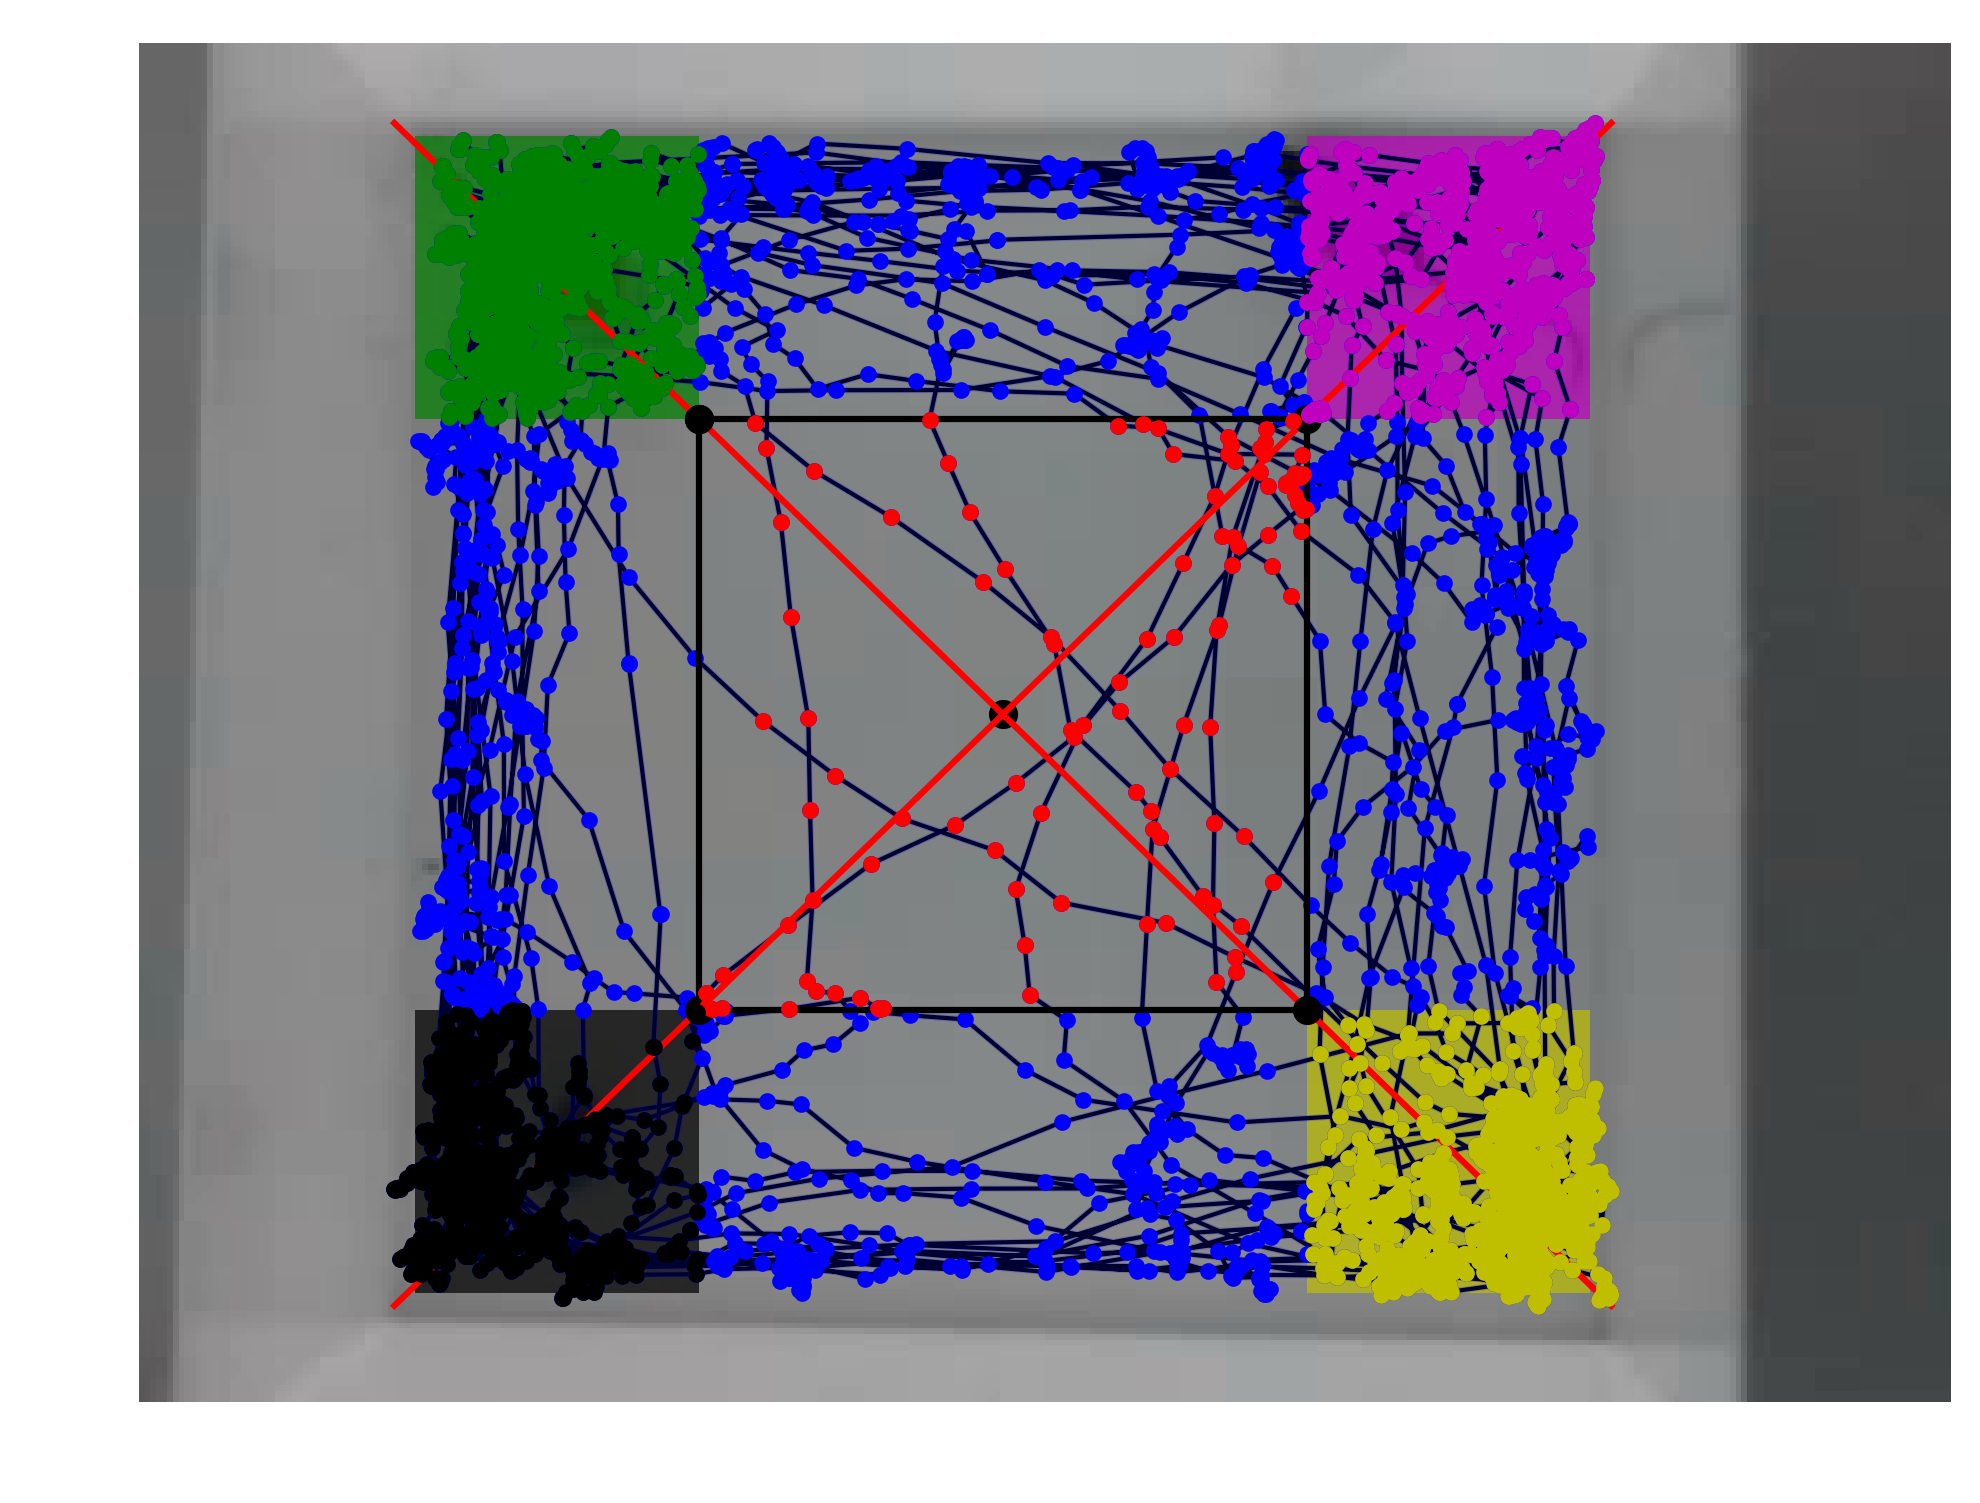

In [54]:
center_to_corners_ratio(filename, '.avi')


In [3]:
filename='/media/amr/Amr_4TB/velocity_deeplabcut/R51_Test_day_24h_delay_OR_Exp_2017_05_05_R50.51.52.53.54.48_20170510_101316_compressed.h5'